# Homework 4

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import re

## Task 0 Loading the data

We load the data, using an appropriate encoding - after error-and-trial:

In [277]:
train = pd.read_csv("data/reddit_200k_train.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])
test = pd.read_csv("data/reddit_200k_test.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])

We peek at our train data:

In [278]:
train.head()

,body,REMOVED
0,I've always been taught it emerged from the ea...,False
1,"As an ECE, my first feeling as ""HEY THAT'S NOT...",True
2,Monday: Drug companies stock dives on good new...,True
3,i learned that all hybrids are unfertile i won...,False
4,Well i was wanting to get wasted tonight. Not...,False


How many instances do we have?

In [279]:
train.shape

(167529, 2)

#### Evaluation metric:

Let us see the proportion of each class in the training data:

In [280]:
target_counts = np.bincount(train['REMOVED'])
print("There are {:d} of the `True` class.".format(target_counts[1]))
print("There are {:d} of the `False` class.".format(target_counts[0]))

There are 64738 of the `True` class.
There are 102791 of the `False` class.


We have a bit of an imbalance problem here, so we'll choose to evaluate our algorithms using the **ROC AUC**, which should give insight on the performance of our models without being too misleading with regard to the class imbalance.

## Task 1 Bag of Words and simple Features

### 1.1 Create a baseline model using a bag-of-words approach and a linear model.

In [281]:
from sklearn.feature_extraction.text import CountVectorizer

We instantiate the BoW model with default parameters (the token pattern excluding one letter words, no limitation on features extracted, no minimum requirements on the number of documents a word appears in, and no filter on stop words):

In [282]:
vect = CountVectorizer()

We fit the model to fetch the vocabulary and use it to transform our data to a BoW:

In [283]:
train_bag = vect.fit_transform(train['body'])

In [284]:
train_bag

<167529x113804 sparse matrix of type '<class 'numpy.int64'>'
	with 5016678 stored elements in Compressed Sparse Row format>

How many different type of tokens were created?

In [285]:
len(vect.vocabulary_)

113804

We look at a few samples of the vocabulary:

In [286]:
vect.get_feature_names()[::10000]

['00',
 '663',
 'babysitter',
 'compassing',
 'eggsâ',
 'greenaway',
 'kajillion',
 'mosanto',
 'phylogenetic',
 'russkies',
 'surrogacy',
 'warned']

We now fit a - AUC-driven, grid-searched - linear model (logistic regression with L2 penalty) on top of this BoW representation:

In [287]:
from sklearn.linear_model import LogisticRegressionCV

In [288]:
baseline = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [289]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    baseline.fit(train_bag, train['REMOVED'])

We retrieve the cross-validation auc for the best model:

In [290]:
auc_base = baseline.scores_[True].mean(axis=0).max()
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


We plot the **PR and ROC curves** on the **test set** and compute the AUC to gain more insight on the model performance (*we will do so for the baseline, the preferred model we build from a BoW representation in Task 1 and the preferred model using word vectors in Task 2*):

In [291]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [292]:
test_bag = vect.transform(test['body'])

In [293]:
baseline_auc = roc_auc_score(test['REMOVED'], 
                             baseline.predict_proba(test_bag)[:, 1])

In [294]:
print("The BASELINE MODEL auc is .{0:.3f}".format(baseline_auc))

The BASELINE MODEL auc is .0.768


In [295]:
precision, recall, _ = precision_recall_curve(test['REMOVED'], 
                                              baseline.predict_proba(test_bag)[:, 1])
fpr, tpr, _ = roc_curve(test['REMOVED'], 
                        baseline.predict_proba(test_bag)[:, 1])

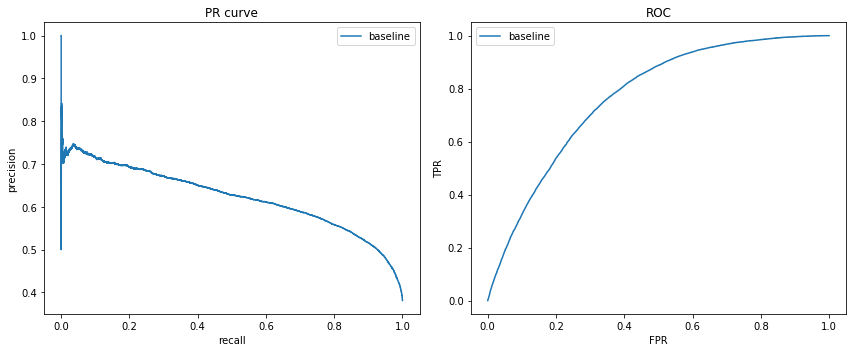

In [296]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

One shouldn't be too surprised at the PR curve, which looks chaotic for low recalls. A PR curve should be monotonous with respect to recall but not precision necessarily. Having some misclassified points with probabilities far from their true classes can lead to such a curve as above.

The overall performance of the baseline looks pretty suboptimal and we will explore ways to improve it in the following.

### 1.2 Try using n-grams, characters, tf-idf rescaling and possibly other ways to tune the BoWmodel. Be aware that you might need to adjust the (regularization of the) linear model for different feature sets.

**We will try different strategies to modify the BoW representation - and hopefully improve it -, always reporting the validation AUC to compare to the baseline.**

**We will also plot PR and ROC curves on the test set for the most promising model and compare those to the baseline.**

#### Using n-grams

We will try to fit a model with an n-gram representation with n ranging from 1 to 2 - choosing a minimum of documents in which a word appear to be 6 to limit the number of features - in an effort to avoid overfitting with an overbearing number of features compared to the number of training instances.

In [24]:
ngram_vect = CountVectorizer(ngram_range=(1, 2), min_df=6)

In [25]:
train_ngram_bag = ngram_vect.fit_transform(train['body'])

The vocabulary size is now:

In [26]:
len(ngram_vect.vocabulary_)

147372

Examples of tokens:

In [27]:
ngram_vect.get_feature_names()[::10000]

['00',
 'and pretend',
 'bertrand',
 'contacts',
 'empirical data',
 'get something',
 'in being',
 'lentils',
 'myopia',
 'org 2018',
 'rats do',
 'smoking cigs',
 'that wasn',
 'to bind',
 'went down']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [28]:
ngram_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [29]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ngram_model.fit(train_ngram_bag, train['REMOVED'])

Compare with baseline:

In [30]:
auc_ngram = ngram_model.scores_[True].mean(axis=0).max()
print('The logistic regression N-GRAM MODEL validation roc auc is {0:.3f}'.format(auc_ngram))

The logistic regression N-GRAM MODEL validation roc auc is 0.763


In [31]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


We have a slight improvement of AUC, but we also added close to 30,000 features. The improvement does not seem to justify the large increase in number of features. We might need to combine n-grams with other tuning parameters to obtain a sensible gain in AUC.

#### Using characters

We now fit a model with an n-gram character representation with n ranging from 2 to 4 - choosing a minimum of documents in which a word appear to be 6 to limit the number of features.

In [32]:
char_vect = CountVectorizer(ngram_range=(2, 4), min_df=6, analyzer='char')

In [33]:
train_char_bag = char_vect.fit_transform(train['body'])

The vocabulary size is now:

In [34]:
len(char_vect.vocabulary_)

126910

Examples of tokens:

In [35]:
char_vect.get_feature_names()[::10000]

['\t&',
 '"wai',
 '/) a',
 '4/) ',
 'a, t',
 'cow ',
 'ere&',
 'i "',
 'llow',
 'o ht',
 'rb ',
 't/47',
 'wths']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [36]:
char_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [37]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    char_model.fit(train_char_bag, train['REMOVED'])

Compare with baseline:

In [38]:
auc_char = char_model.scores_[True].mean(axis=0).max()
print('The logistic regression CHARACTER MODEL validation roc auc is {0:.3f}'.format(auc_char))

The logistic regression CHARACTER MODEL validation roc auc is 0.780


In [39]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


The AUC has significantly improved with an addition of 10,000 features (~10% of baseline features), using character n-grams seems promising. We will try to incorporate it and combine it with other tuning parameters to find a better model.

#### Using tf-idf rescaling

We know use tf-idf weighting on the word counts with a base word count vectorizer (and l2 normalization on each row).

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfidf_vect = TfidfVectorizer()

In [42]:
train_tfidf_bag = tfidf_vect.fit_transform(train['body'])

The vocabulary size is now:

In [43]:
len(tfidf_vect.vocabulary_)

113804

As expected, it is the same as the baseline vocabulary size - only the count values are now weighted using the tf-idf scheme.

Examples of tokens:

In [44]:
tfidf_vect.get_feature_names()[::10000]

['00',
 '663',
 'babysitter',
 'compassing',
 'eggsâ',
 'greenaway',
 'kajillion',
 'mosanto',
 'phylogenetic',
 'russkies',
 'surrogacy',
 'warned']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [45]:
tfidf_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [46]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tfidf_model.fit(train_tfidf_bag, train['REMOVED'])

Compare with baseline:

In [47]:
auc_tfidf = tfidf_model.scores_[True].mean(axis=0).max()
print('The logistic regression TFIDF MODEL validation roc auc is {0:.3f}'.format(auc_tfidf))

The logistic regression TFIDF MODEL validation roc auc is 0.768


In [48]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


The results are better than the baseline, less significantly so than just using character n-grams without tf-idf. One could hope that combining both will significantly improve our metrics.

#### Throwing away stop words

In [57]:
stop_vect = CountVectorizer(stop_words="english")

In [58]:
train_stop_bag = stop_vect.fit_transform(train['body'])

In [59]:
len(stop_vect.vocabulary_)

113494

In [60]:
stop_vect.get_feature_names()[::10000]

['00',
 '663',
 'backdoors',
 'complacency',
 'ehp2773',
 'griffiths',
 'karelin',
 'mounties',
 'piercings',
 's00426',
 'sweatiest',
 'weakening']

Cross-validating (grid-searching the best regularization parameter) the logistic regression:

In [61]:
stop_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [62]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stop_model.fit(train_stop_bag, train['REMOVED'])

Compare with baseline:

In [63]:
auc_stop = stop_model.scores_[True].mean(axis=0).max()
print('The logistic regression STOP-WORDS MODEL validation roc auc is {0:.3f}'.format(auc_stop))

The logistic regression STOP-WORDS MODEL validation roc auc is 0.752


In [64]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


Removing stop words actually worsens the performance of the baseline! It seems that stop words might be informative in our context of moderating the thread.

#### Combining different tuning parameters

We now combine several tuning parameters to hopefully get better validation results. Splitting the data into character n-grams seemed promising, so *we decided to combine this representation with a tf-idf weighting, removing character n-grams that are too rare*.

In [50]:
comb_vect = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=6)

In [51]:
train_comb_bag = comb_vect.fit_transform(train['body'])

In [53]:
len(comb_vect.vocabulary_)

126910

In [54]:
comb_vect.get_feature_names()[::10000]

['\t&',
 '"wai',
 '/) a',
 '4/) ',
 'a, t',
 'cow ',
 'ere&',
 'i "',
 'llow',
 'o ht',
 'rb ',
 't/47',
 'wths']

In [55]:
comb_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [56]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    comb_model.fit(train_comb_bag, train['REMOVED'])

In [57]:
auc_comb = comb_model.scores_[True].mean(axis=0).max()
print('The logistic regression COMBINED MODEL validation roc auc is {0:.3f}'.format(auc_comb))

The logistic regression COMBINED MODEL validation roc auc is 0.789


In [58]:
print('The logistic regression BASELINE MODEL validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression BASELINE MODEL validation roc auc is 0.759


This is the best ROC AUC we have seen as of yet. **We will stop the model selection process based on the BoW representation only now and report results on the test set of this improved character-tfidf-BoW model**:

In [80]:
comb_bag = comb_vect.transform(test['body'])

In [82]:
comb_model_auc = roc_auc_score(test['REMOVED'], 
                               comb_model.predict_proba(comb_bag)[:, 1])

In [84]:
print("The AUC on the test set is {0:.3f}".format(comb_model_auc))

The AUC on the test set is 0.798


In [86]:
print("The AUC of the baseline on the test set is {0:.3f}".format(baseline_auc))

The AUC of the baseline on the test set is 0.768


In [91]:
precision2, recall2, _ = precision_recall_curve(test['REMOVED'], 
                                              comb_model.predict_proba(comb_bag)[:, 1])
fpr2, tpr2, _ = roc_curve(test['REMOVED'], 
                        comb_model.predict_proba(comb_bag)[:, 1])

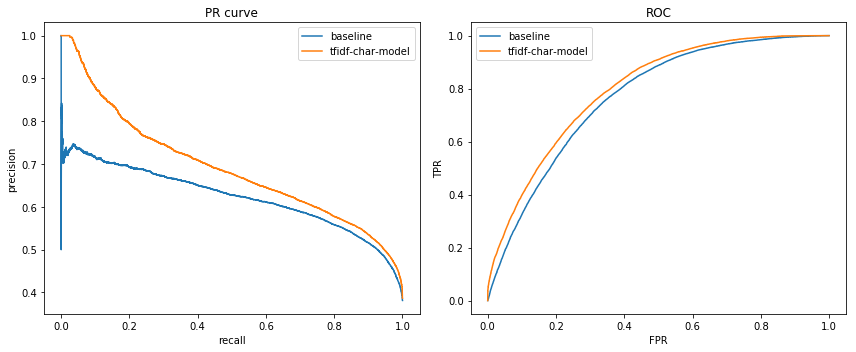

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].plot(recall2, precision2, label="tfidf-char-model")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].plot(fpr2, tpr2, label="tfidf-char-model")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

The new model performs better on the test data as both its curves are systematically above the baseline's.

### 1.3 Explore other features you can derive from the text, such as html, length, punctuation,capitalization or other features you deem important from exploring the dataset

Ideas: 

from https://www.kaggle.com/alber8295/kisa-md-trabajo-final-an-lisis-de-datos
clean words for the ngram part (keep only letters and spaces)

from https://www.kaggle.com/areeves87/xgb-lgbm-glmnet-on-text2vec-tf-idf-auc-0-821
stemming before making BoW

from https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams/code
limit the number of features

from https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
length of the comment in words,
length of the comment in characters

from https://www.kaggle.com/areeves87/nbsvm-w-char-grams-auc-824
combine both word and character mappings (with hstack)

In [316]:
train = pd.read_csv("data/reddit_200k_train.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])
test = pd.read_csv("data/reddit_200k_test.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])

In [299]:
#Cleaning the numbers for reducing the number of features

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

train['body'] = train['body'].apply(lambda x: clean_numbers(x))

In [301]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=6) 

In [302]:
train_bag = vect.fit_transform(train['body'])

len(vect.vocabulary_)

114198

In [331]:
# Counting the number of punctuation characters in the text
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def count_punct(text):
    counter = 0
    for character in list(text):
        if character in punct:
            counter += 1
    return counter

train['count_punct'] = train['body'].apply(lambda x: count_punct(x))

In [332]:
# Counting the number of uppercase character in the string

def count_upper(text):
    return sum(1 for c in list(text) if c.isupper())

train['count_upper'] = train['body'].apply(lambda x: count_punct(x))

In [333]:
# Counting the number of characters

def count_char(text):
    return sum(1 for c in list(text))

train['count_char'] = train['body'].apply(lambda x: count_char(x))

In [334]:
# Counting the number of words

def count_words(text):
    return sum(1 for c in text.split(' '))

train['count_words'] = train['body'].apply(lambda x: count_words(x))

In [335]:
# Counting the max number of occurence of the same character
# We can observe that some users tend to repeat many times the same character
# like in 'ooooooooooh' which can be related to the fact that it should be removed

from collections import Counter
import operator

def count_max_char_occ(text):
    counter = Counter(text)
    return max(counter.items(), key=operator.itemgetter(1))[1]

train['count_max_char_occ'] = train['body'].apply(lambda x: count_max_char_occ(x))

In [308]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
import scipy.sparse
import scipy

count_punct = scipy.sparse.csr_matrix(train['count_punct'].values.reshape((train.shape[0],1)))
count_max_char_occ = scipy.sparse.csr_matrix(train['count_max_char_occ'].values.reshape((train.shape[0],1)))
count_words = scipy.sparse.csr_matrix(train['count_words'].values.reshape((train.shape[0],1)))
count_char = scipy.sparse.csr_matrix(train['count_char'].values.reshape((train.shape[0],1)))
count_upper = scipy.sparse.csr_matrix(train['count_upper'].values.reshape((train.shape[0],1)))

 

X_train = scipy.sparse.hstack([train_bag, count_punct,count_max_char_occ,count_words,count_char,count_upper])

In [311]:
add_feat_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)

In [312]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_feat_model.fit(X_train, train['REMOVED'])

We retrieve the cross-validation auc for the best model:

In [313]:
auc_add_feat_model = add_feat_model.scores_[True].mean(axis=0).max()
print('The logistic regression validation roc auc is {0:.3f}'.format(auc_base))

The logistic regression validation roc auc is 0.759


In [337]:
test['count_punct'] = test['body'].apply(lambda x: count_punct(x))
test['count_upper'] = test['body'].apply(lambda x: count_punct(x))
test['count_char'] = test['body'].apply(lambda x: count_char(x))
test['count_words'] = test['body'].apply(lambda x: count_words(x))
test['count_max_char_occ'] = test['body'].apply(lambda x: count_max_char_occ(x))

test_bag = vect.transform(test['body'])
count_punct = scipy.sparse.csr_matrix(test['count_punct'].values.reshape((test.shape[0],1)))
count_max_char_occ = scipy.sparse.csr_matrix(test['count_max_char_occ'].values.reshape((test.shape[0],1)))
count_words = scipy.sparse.csr_matrix(test['count_words'].values.reshape((test.shape[0],1)))
count_char = scipy.sparse.csr_matrix(test['count_char'].values.reshape((test.shape[0],1)))
count_upper = scipy.sparse.csr_matrix(test['count_upper'].values.reshape((test.shape[0],1)))

X_test = scipy.sparse.hstack([test_bag, count_punct,count_max_char_occ,count_words,count_char,count_upper])

In [338]:
add_feat_model_auc = roc_auc_score(test['REMOVED'], 
                               add_feat_model.predict_proba(X_test)[:, 1])

In [339]:
print("The AUC on the test set is {0:.3f}".format(add_feat_model_auc))

The AUC on the test set is 0.795


In [340]:
print("The AUC of the baseline on the test set is {0:.3f}".format(baseline_auc))

The AUC of the baseline on the test set is 0.768


In [341]:
precision3, recall3, _ = precision_recall_curve(test['REMOVED'], 
                                              add_feat_model.predict_proba(X_test)[:, 1])
fpr3, tpr3, _ = roc_curve(test['REMOVED'], 
                        add_feat_model.predict_proba(X_test)[:, 1])

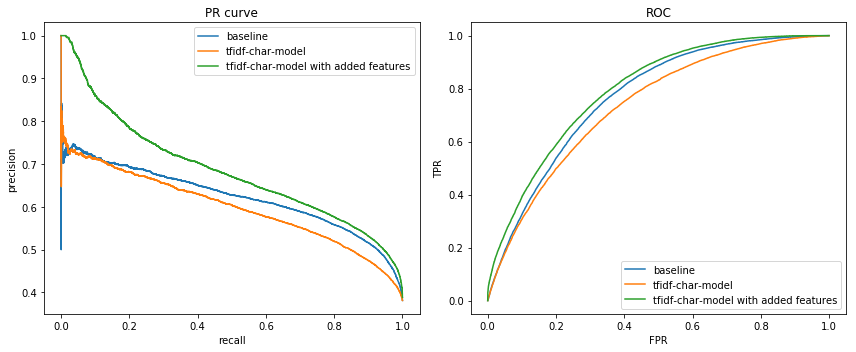

In [342]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].plot(recall2, precision2, label="tfidf-char-model")
ax[0].plot(recall3, precision3, label="tfidf-char-model with added features")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].plot(fpr2, tpr2, label="tfidf-char-model")
ax[1].plot(fpr3, tpr3, label="tfidf-char-model with added features")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")

fig.tight_layout()

## Task 2 Word Vectors

### Use a pretrained word-embedding (word2vec, glove or fasttext) instead of the bag-of-words model. Does this improve classification?

In [253]:
from nltk import word_tokenize

train = pd.read_csv("data/reddit_200k_train.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])
test = pd.read_csv("data/reddit_200k_test.csv", encoding="ISO-8859-1", usecols=["body", "REMOVED"])

We start by loading the embedding in memory: embeddings_index is a dictionnary with words as keys and vectors as values

In [183]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')


embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) 
                        for i,o in enumerate(
                            open("data/fasttext/"+
                                    "crawl-300d-2M.vec")))

Then, we tokenize the sentences using nltk and remove the stopwords.

In [254]:
from nltk import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

x = train['body']

def tokenize_func(text):
    tokenized_text = []
    unwanted_words = set(stopwords.words('english'))
    for i in range(len(text)):
        comment = text[i].lower()
        string_arr = word_tokenize(comment)
        filtered_array = []
        
        for word in string_arr:
            if word not in unwanted_words:
                #filtered_array.append(lemmatizer.lemmatize(word))
                filtered_array.append(word)
        tokenized_text.append(filtered_array)
    return tokenized_text

tokenized_text = tokenize_func(x)

We can visualize the token we have created and see what are the most common tokens.

In [246]:
from collections import Counter
print(sorted(Counter([item for sublist in tokenized_text 
                for item in sublist]).items(), key=operator.itemgetter(1))[::-1][:10])

[('.', 311260), (',', 241534), ('?', 75961), (')', 40847), (':', 40615), ('(', 39373), ('people', 28719), ('would', 27679), ("'s", 27229), ('like', 25634)]


Among the most common words, we can see two different patterns: there are punctuation symbols and part of contracted expressions (like the "n't"). Having the punctuation as a token is probably a good thing because it is over-used in removed message. However, contractions are a problem because they will not be embedded because they are badly tokenized.

Let us check the quality of the coverage ie the ratio of words that can be embedded with the embedding. This is a crucial part: the more embedded words, the more informative the final vector will be.

In [255]:
def check_coverage(tokenized_text,embeddings_index):

    flat_list = [item for sublist in tokenized_text for item in sublist]
    vocab = flat_list
    nb_of_words = len(list(set(vocab)))

    a = dict()
    oov = dict()
    k = 0
    i = 0

    for word in vocab:
        if word in embeddings_index:
            k += 1
            if word in a:
                a[word] +=1
            else:
                a[word] =1
        else:
            if word in oov:
                oov[word] +=1
            else:
                oov[word] =1
            i += 1
    return sorted(oov.items(), key=operator.itemgetter(1))[::-1],k,i,nb_of_words

In [248]:
oov,k,i,nb_of_words = check_coverage(tokenized_text,embeddings_index)

print("{:.2f}% of the words are covered by the embedding".format((float(nb_of_words-len(oov))/(nb_of_words))*100))

49.48% of the words are covered by the embedding


In [229]:
oov[:10]

[("n't", 41436),
 ("''", 24963),
 ('``', 23428),
 ('itâ\x80\x99s', 1698),
 ('donâ\x80\x99t', 1183),
 ('**', 1171),
 ('iâ\x80\x99m', 1123),
 ('it\x92s', 949),
 ('//www.reddit.com/message/compose', 940),
 ('2fscience', 914)]

We can see that the coverage is not great: about half of the words are present in the embedding. Among the most common out-of-vocabulary words, we can see that there are badly tokenized words, special chars, and contracted expression. 

Let us try to clean the text to improve the coverage.

First, we will revert the most common contractions.

In [256]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

train['body'] = train['body'].apply(lambda x: clean_contractions(x,contraction_mapping))

There also seem to be an encoding issue for the ' character: we have 'itâ\x80\x99s' which is very likely to be "it's" as well as 'it\x92s' that should also be "it's". 

In [257]:
def clean_bad_encoding(x):

    x = str(x)
    return x.replace('\x92',"'").replace('â\x80\x99',"'")

train['body'] = train['body'].apply(lambda x: clean_bad_encoding(x))
#We reapply the clean_contractions function 
train['body'] = train['body'].apply(lambda x: clean_contractions(x,contraction_mapping))

In [258]:
tokenized_text = tokenize_func(train['body'])
oov,k,i,nb_of_words = check_coverage(tokenized_text,embeddings_index)

print("{:.2f}% of the words are covered by the embedding".format((float(nb_of_words-len(oov))/(nb_of_words))*100))

52.06% of the words are covered by the embedding


In [242]:
oov[:10]

[("''", 24969),
 ('``', 23423),
 ("n't", 5655),
 ('**', 1171),
 ('//www.reddit.com/message/compose', 940),
 ('2fscience', 914),
 ('2fr', 914),
 ('to=', 914),
 ('message=my', 911),
 ('20post', 909)]

In [265]:
def vectorize_text(tokenized_text):
    vector_x = []
    for sentence in tokenized_text:
        sentence_x = []
        for word in sentence:
            if word in embeddings_index:
                vector = embeddings_index[word]
            else:
                vector = np.array([0.0] * 300)
            sentence_x.append(vector)
        #It seems that one of the body text has no word in the embedding
        #The if statement allows us to tackle that
        if(len(sentence)==0):
            vector_x.append(np.array([0.0] * 300))
        else:
            vector_x.append(np.mean(np.array(sentence_x),axis=0).reshape(300))

    return np.array(vector_x)

In [260]:
emb_model = LogisticRegressionCV(scoring='roc_auc', random_state=20190409)


In [261]:
# to avoid convergence warnings popping up
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    emb_model.fit(vector_x, train['REMOVED'])
    

In [262]:
auc_vec = emb_model.scores_[True].mean(axis=0).max()
print('The logistic regression MODEL  with Fastext embedding validation roc auc is {0:.3f}'.format(auc_vec))

The logistic regression COMBINED MODEL validation roc auc is 0.733


In [273]:
test['body'] = test['body'].apply(lambda x: clean_bad_encoding(x))
#We reapply the clean_contractions function 
test['body'] = test['body'].apply(lambda x: clean_contractions(x,contraction_mapping))
tokenized_text_test = tokenize_func(test['body'])
X_test = vectorize_text(tokenized_text_test)

In [274]:
emb_model_auc = roc_auc_score(test['REMOVED'], 
                               emb_model.predict_proba(X_test)[:, 1])

In [275]:
print("The AUC on the test set is {0:.3f}".format(emb_model_auc))

The AUC on the test set is 0.735


In [276]:
precision4, recall4, _ = precision_recall_curve(test['REMOVED'], 
                                              emb_model.predict_proba(X_test)[:, 1])
fpr4, tpr4, _ = roc_curve(test['REMOVED'], 
                        emb_model.predict_proba(X_test)[:, 1])

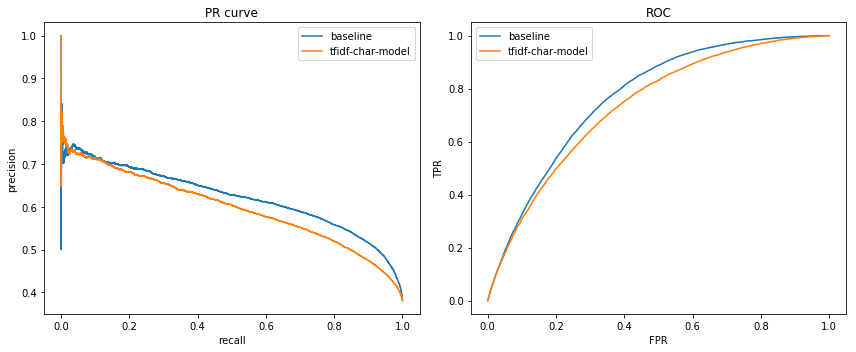

In [297]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].plot(recall, precision, label="baseline")
ax[0].plot(recall2, precision2, label="tfidf-char-model")
ax[0].plot(recall3, precision3, label="embedding-based model")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("PR curve")
ax[0].legend(loc="best")

ax[1].plot(fpr, tpr, label="baseline")
ax[1].plot(fpr2, tpr2, label="tfidf-char-model")
ax[0].plot(fpr3, tpr3, label="embedding-based model")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC")
ax[1].legend(loc="best")


fig.tight_layout()